# Pulling Data from GCS and Clickhouse

In [1]:
# ----------------------------------------
# Imports
# ----------------------------------------

# Core libraries
import pandas as pd
import polars as pl
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical testing
from scipy.stats import mannwhitneyu

# Internal data access
from op_analytics.coreutils.duckdb_inmem.client import init_client, register_parquet_relation
from op_analytics.coreutils.clickhouse.oplabs import run_query_oplabs

# ----------------------------------------
# Configurations
# ----------------------------------------

# Flashblock event context
FLASHBLOCK_DATE = pd.Timestamp("2025-07-16")
NUM_DAYS = 7

# Polars display config
pl.Config.set_tbl_cols(100)
pl.Config.set_tbl_rows(100)
pl.Config.set_fmt_str_lengths(80)

# Seaborn styling
sns.set_theme(style="whitegrid")


In [2]:
# Create dates before and after flashblock launch on base
start_date = FLASHBLOCK_DATE - pd.Timedelta(days=NUM_DAYS)
end_date = FLASHBLOCK_DATE + pd.Timedelta(days=NUM_DAYS)

dates = pd.date_range(start_date, end_date).strftime("%Y-%m-%d").tolist()
dates

['2025-07-09',
 '2025-07-10',
 '2025-07-11',
 '2025-07-12',
 '2025-07-13',
 '2025-07-14',
 '2025-07-15',
 '2025-07-16',
 '2025-07-17',
 '2025-07-18',
 '2025-07-19',
 '2025-07-20',
 '2025-07-21',
 '2025-07-22',
 '2025-07-23']

In [3]:
# Read transaction fees data from GCS into DuckDB
chain = "base"
parquet_paths = [
    f"gs://oplabs-tools-data-sink/blockbatch/refined_traces/refined_transactions_fees_v2/chain=base/dt={date}/*.parquet"
    for date in dates
]

# Load into DuckDB
ctx = init_client()
tx_fees_view = register_parquet_relation("refined_transactions_fees_v2", parquet_paths)

2025-07-30 21:34:14 [info     ] initialized duckdb at /var/folders/80/jqw6kmgj7j34j0x4mcs6hcl00000gn/T/vz6uowvk/op-analytics.duck.db filename=client.py lineno=118 process=49331
2025-07-30 21:34:14 [info     ] loaded vault from .env file    filename=vault.py lineno=32 process=49331
2025-07-30 21:34:14 [debug    ] loaded vault: 28 items         filename=vault.py lineno=79 process=49331
2025-07-30 21:34:14 [info     ] create duckddb gcs secret      filename=client.py lineno=66 process=49331
2025-07-30 21:34:22 [info     ] registered view: 'refined_transactions_fees_v2' using 15 parquet paths filename=client.py lineno=319 process=49331


In [4]:
# Preview data 
df_sample = ctx.client.sql(f"SELECT * FROM {tx_fees_view} LIMIT 10").pl()

print(df_sample)

df_sample.schema

shape: (10, 59)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ cha ┆ net ┆ non ┆ tra ┆ fro ┆ to_ ┆ blo ┆ blo ┆ has ┆ tra ┆ gas ┆ gas ┆ l2_ ┆ rec ┆ l1_ ┆ l1_ ┆ l1_ ┆ bas ┆ max ┆ eff ┆ l1_ ┆ l1_ ┆ l1_ ┆ leg ┆ l2_ ┆ l2_ ┆ l2_ ┆ met ┆ suc ┆ inp ┆ inp ┆ is_ ┆ is_ ┆ blo ┆ est ┆ l1_ ┆ tx_ ┆ l2_ ┆ l1_ ┆ l1_ ┆ l1_ ┆ l1_ ┆ tx_ ┆ l1_ ┆ l2_ ┆ l1_ ┆ l1_ ┆ l2_ ┆ l2_ ┆ l2_ ┆ l2_ ┆ l2_ ┆ max ┆ l2_ ┆ l2_ ┆ l1_ ┆ l1_ ┆ cha ┆ dt  │
│ in_ ┆ wor ┆ ce  ┆ nsa ┆ m_a ┆ add ┆ ck_ ┆ ck_ ┆ h   ┆ nsa ┆ _pr ┆ _li ┆ gas ┆ eip ┆ fee ┆ gas ┆ blo ┆ e_f ┆ _pr ┆ ect ┆ fee ┆ bas ┆ blo ┆ acy ┆ fee ┆ pri ┆ bas ┆ hod ┆ ces ┆ ut_ ┆ ut_ ┆ sys ┆ att ┆ ck_ ┆ ima ┆ gas ┆ fee ┆ leg ┆ bas ┆ bas ┆ blo ┆ blo ┆ fee ┆ fee ┆ fee ┆ 

Schema([('chain_id', Int32),
        ('network', String),
        ('nonce', Int64),
        ('transaction_index', Int64),
        ('from_address', String),
        ('to_address', String),
        ('block_number', Int64),
        ('block_timestamp', UInt32),
        ('hash', String),
        ('transaction_type', Int32),
        ('gas_price', Int64),
        ('gas_limit', Int64),
        ('l2_gas_used', Int64),
        ('receipt_l1_gas_used', Int64),
        ('l1_fee', Int64),
        ('l1_gas_price', Int64),
        ('l1_blob_base_fee', Int64),
        ('base_fee_per_gas', Int64),
        ('max_priority_fee_per_gas', Int64),
        ('effective_l2_priority_fee_per_gas', Int64),
        ('l1_fee_scalar', Decimal(precision=12, scale=6)),
        ('l1_base_fee_scalar', Decimal(precision=26, scale=7)),
        ('l1_blob_base_fee_scalar', Decimal(precision=26, scale=7)),
        ('legacy_extra_fee_per_gas', Int64),
        ('l2_fee', Int64),
        ('l2_priority_fee', Int64),
        ('l2_b

In [5]:
# Query clickhouse to pull label data for bots
query = "SELECT contract FROM hex_uploads.likely_bot_contracts group by 1"
bot_labels_df = run_query_oplabs(query)

print(bot_labels_df.head())

# Register the clickhouse result in DuckDB for joining
bot_labels_view = "likely_bot_contracts"
ctx.client.register(bot_labels_view, bot_labels_df)

2025-07-30 21:34:45 [debug    ] connecting to OPLABS Clickhouse client... filename=client.py lineno=56 process=49331
2025-07-30 21:34:45 [debug    ] initialized OPLABS Clickhouse client. filename=client.py lineno=61 process=49331
shape: (5, 1)
┌────────────────────────────────────────────┐
│ contract                                   │
│ ---                                        │
│ str                                        │
╞════════════════════════════════════════════╡
│ 0x308513ec34509fbddf67782d0e1ffd026ead576f │
│ 0x45c55bf488d3cb8640f12f63cbedc027e8261e79 │
│ 0x2e06c90bf01d2d81614c90a3ccc34e8bbcb75302 │
│ 0x804ce9101dc5edf25a4237ebb55385a8d93a0474 │
│ 0xeec9a6875dcb62a3cb416b3f8c6a3f4117f38820 │
└────────────────────────────────────────────┘


In [6]:
formatted_flashblock_date = FLASHBLOCK_DATE.strftime("%Y-%m-%d")

TX_FEES_QUERY = (
    f"""
    SELECT 
        chain_id,
        network,
        dt,
        CASE 
            WHEN dt > '{formatted_flashblock_date}' THEN 'post-flashblock'
            ELSE 'pre-flashblock'
        END AS flashblock_period,
        to_address,
        transaction_index,
        hash,
        block_number,
        success,
        tx_fee_native,
        l1_fee_native,
        l2_base_fee_native,
        l2_priority_fee_native,
        l2_legacy_extra_fee_native,
        l2_gas_used,
        100 * l1_fee_native / tx_fee_native AS pct_l1_fee,
        100 * l2_base_fee_native / tx_fee_native AS pct_l2_base_fee,
        100 * l2_priority_fee_native / tx_fee_native AS pct_l2_priority_fee,
        100 * l2_legacy_extra_fee_native / tx_fee_native AS pct_l2_legacy_extra_fee
    FROM {tx_fees_view}
    SEMI JOIN {bot_labels_view} 
    ON {tx_fees_view}.to_address = {bot_labels_view}.contract
    WHERE gas_price > 0
    """
)

# Execute the query and load into polars
combined_df = ctx.client.sql(TX_FEES_QUERY).pl()
print(combined_df)

shape: (71_000_417, 19)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ cha ┆ net ┆ dt  ┆ fla ┆ to_ ┆ tra ┆ has ┆ blo ┆ suc ┆ tx_ ┆ l1_ ┆ l2_ ┆ l2_ ┆ l2_ ┆ l2_ ┆ pct ┆ pct ┆ pct ┆ pct │
│ in_ ┆ wor ┆ --- ┆ shb ┆ add ┆ nsa ┆ h   ┆ ck_ ┆ ces ┆ fee ┆ fee ┆ bas ┆ pri ┆ leg ┆ gas ┆ _l1 ┆ _l2 ┆ _l2 ┆ _l2 │
│ id  ┆ k   ┆ dat ┆ loc ┆ res ┆ cti ┆ --- ┆ num ┆ s   ┆ _na ┆ _na ┆ e_f ┆ ori ┆ acy ┆ _us ┆ _fe ┆ _ba ┆ _pr ┆ _le │
│ --- ┆ --- ┆ e   ┆ k_p ┆ s   ┆ on_ ┆ str ┆ ber ┆ --- ┆ tiv ┆ tiv ┆ ee_ ┆ ty_ ┆ _ex ┆ ed  ┆ e   ┆ se_ ┆ ior ┆ gac │
│ i32 ┆ str ┆     ┆ eri ┆ --- ┆ ind ┆     ┆ --- ┆ boo ┆ e   ┆ e   ┆ nat ┆ fee ┆ tra ┆ --- ┆ --- ┆ fee ┆ ity ┆ y_e │
│     ┆     ┆     ┆ od  ┆ str ┆ ex  ┆     ┆ i64 ┆ l   ┆ --- ┆ --- ┆ ive ┆ _na ┆ _fe ┆ i64 ┆ f64 ┆ --- ┆ _fe ┆ xtr │
│     ┆     ┆     ┆ --- ┆     ┆ --- ┆     ┆     ┆     ┆ dec ┆ dec ┆ --- ┆ tiv ┆ e_n ┆     ┆     ┆ f64 ┆ e   ┆ a_f │
│     ┆     ┆     ┆ str ┆     ┆ i64 ┆     ┆     

In [7]:
combined_df.group_by("dt").count()

/var/folders/80/jqw6kmgj7j34j0x4mcs6hcl00000gn/T/ipykernel_49331/706061727.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  combined_df.group_by("dt").count()


dt,count
date,u32
2025-07-15,4984839
2025-07-12,4229407
2025-07-09,4475921
2025-07-13,4366143
2025-07-11,4603508
2025-07-14,4851347
2025-07-23,4509248
2025-07-19,4589247
2025-07-20,5440660


In [8]:
df_casted = combined_df.with_columns([
    pl.col("tx_fee_native").cast(pl.Float64),
    pl.col("l1_fee_native").cast(pl.Float64),
    pl.col("l2_base_fee_native").cast(pl.Float64),
    pl.col("l2_priority_fee_native").cast(pl.Float64),
    pl.col("l2_legacy_extra_fee_native").cast(pl.Float64)
])

# Pre and Post Flashblock Summary

In [11]:
summary_tx_level = df_casted.group_by("flashblock_period").agg([
    pl.col("tx_fee_native").mean().alias("avg_tx_fee_native"),
    pl.col("l1_fee_native").mean().alias("avg_l1_fee_native"),
    pl.col("l2_base_fee_native").mean().alias("avg_l2_base_fee_native"),
    pl.col("l2_priority_fee_native").mean().alias("avg_l2_priority_fee_native"),
    pl.col("l2_legacy_extra_fee_native").mean().alias("avg_l2_legacy_fee_native"),
    pl.col("l2_gas_used").mean().alias("avg_l2_gas_used"),
    pl.col("pct_l1_fee").mean().alias("avg_pct_l1_fee"),
    pl.col("pct_l2_base_fee").mean().alias("avg_pct_l2_base_fee"),
    pl.col("pct_l2_priority_fee").mean().alias("avg_pct_l2_priority_fee"),
    pl.col("pct_l2_legacy_extra_fee").mean().alias("avg_pct_l2_legacy_extra_fee"),
    (pl.col("success").sum() / pl.len()).alias("tx_success_rate")
])

summary_tx_level

flashblock_period,avg_tx_fee_native,avg_l1_fee_native,avg_l2_base_fee_native,avg_l2_priority_fee_native,avg_l2_legacy_fee_native,avg_l2_gas_used,avg_pct_l1_fee,avg_pct_l2_base_fee,avg_pct_l2_priority_fee,avg_pct_l2_legacy_extra_fee,tx_success_rate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""pre-flashblock""",0.000007,4.0325e-8,0.000001,0.000005,0.000001,303164.483957,4.245785,54.490943,34.048135,7.215138,0.84184
"""post-flashblock""",0.000007,3.5462e-8,0.000003,0.000003,0.000001,288466.946063,2.104039,71.467236,22.040775,4.38795,0.867537


In [10]:
bot_block_level_df = df_casted.group_by([
    "flashblock_period",
    "dt",
    "to_address",
    "block_number"
]).agg([
    pl.len().alias("tx_count"),
    pl.sum("tx_fee_native").alias("total_fee"),
    pl.sum("l1_fee_native").alias("total_l1_fee"),
    pl.sum("l2_base_fee_native").alias("total_l2_base_fee"),
    pl.sum("l2_priority_fee_native").alias("total_l2_priority_fee"),
    pl.sum("l2_legacy_extra_fee_native").alias("total_l2_legacy_fee"),
    pl.sum("l2_gas_used").alias("total_gas_used"),
    pl.sum("success").alias("total_success"),
    
    pl.mean("pct_l1_fee").alias("avg_pct_l1_fee"),
    pl.mean("pct_l2_base_fee").alias("avg_pct_l2_base_fee"),
    pl.mean("pct_l2_priority_fee").alias("avg_pct_l2_priority_fee"),
    pl.mean("pct_l2_legacy_extra_fee").alias("avg_pct_l2_legacy_fee"),
])


In [12]:
# “What does the average bot do in a given block during the pre vs. post-flashblock periods?”
summary_block_level = bot_block_level_df.group_by("flashblock_period").agg([
    pl.mean("tx_count").alias("avg_tx_per_block"),
    pl.mean("total_fee").alias("avg_total_fee_per_block"),
    pl.mean("total_l1_fee").alias("avg_l1_fee_per_block"),
    pl.mean("total_l2_base_fee").alias("avg_l2_base_fee_per_block"),
    pl.mean("total_l2_priority_fee").alias("avg_l2_priority_fee_per_block"),
    pl.mean("total_l2_legacy_fee").alias("avg_l2_legacy_fee_per_block"),
    pl.mean("total_gas_used").alias("avg_gas_used_per_block"),
    (pl.sum("total_success") / pl.sum("tx_count")).alias("avg_tx_success_rate_per_block"),
    pl.mean("avg_pct_l1_fee").alias("avg_pct_l1_fee_per_block"),
    pl.mean("avg_pct_l2_base_fee").alias("avg_pct_l2_base_fee_per_block"),
    pl.mean("avg_pct_l2_priority_fee").alias("avg_pct_l2_priority_fee_per_block"),
    pl.mean("avg_pct_l2_legacy_fee").alias("avg_pct_l2_legacy_fee_per_block")
])

summary_block_level

flashblock_period,avg_tx_per_block,avg_total_fee_per_block,avg_l1_fee_per_block,avg_l2_base_fee_per_block,avg_l2_priority_fee_per_block,avg_l2_legacy_fee_per_block,avg_gas_used_per_block,avg_tx_success_rate_per_block,avg_pct_l1_fee_per_block,avg_pct_l2_base_fee_per_block,avg_pct_l2_priority_fee_per_block,avg_pct_l2_legacy_fee_per_block
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""pre-flashblock""",2.418383,0.000017,9.7522e-8,0.000003,0.000011,0.000003,733167.69873,0.84184,3.016404,51.967722,32.185138,12.830736
"""post-flashblock""",3.108118,0.000021,1.1022e-7,0.000008,0.00001,0.000003,896589.258611,0.867537,1.570739,64.942363,23.551463,9.935435


# Stats and Visualization

In [15]:
# Aggregates block-level metrics per flashblock period
block_df = df_casted.group_by(["flashblock_period", "block_number"]).agg([
    pl.len().alias("tx_count"),
    pl.sum("l2_gas_used").alias("total_gas_used"),
    pl.sum("tx_fee_native").alias("total_fee"),
    pl.sum("l1_fee_native").alias("total_l1_fee"),
    pl.sum("l2_base_fee_native").alias("total_l2_base_fee"),
    pl.sum("l2_priority_fee_native").alias("total_l2_priority_fee"),
    pl.sum("l2_legacy_extra_fee_native").alias("total_l2_legacy_fee"),
])

block_df_pd = block_df.to_pandas()

In [22]:
def compute_stat_summary(df, col):
    pre = df[df["flashblock_period"] == "pre-flashblock"][col]
    post = df[df["flashblock_period"] == "post-flashblock"][col]
    
    stat, p = mannwhitneyu(pre, post, alternative="two-sided")
    med_pre = np.median(pre)
    med_post = np.median(post)
    delta = med_post - med_pre
    
    return p, delta, med_pre, med_post

def plot_kde_with_stats(df, col, xlabel=None, title=None, clip_percentiles=(0.01, 0.99)):
    # Optional clipping to remove outliers
    q_low = df[col].quantile(clip_percentiles[0])
    q_high = df[col].quantile(clip_percentiles[1])
    df_clipped = df[(df[col] >= q_low) & (df[col] <= q_high)]

    # Compute stats
    p, delta, med_pre, med_post = compute_stat_summary(df, col)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.kdeplot(
        data=df_clipped, 
        x=col, 
        hue="flashblock_period", 
        fill=True, 
        common_norm=False, 
        alpha=0.3, 
        hue_order=["pre-flashblock", "post-flashblock"],
        palette={"pre-flashblock": "orange", "post-flashblock": "blue"}, 
    )
    
    # Annotation
    xlabel = xlabel or col
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.axvline(med_pre, linestyle="--", label=f"Pre-flashblock median", alpha=0.6, color="orange")
    plt.axvline(med_post, linestyle="--", label=f"Post-flashblock median", alpha=0.6, color="blue")

    stat_text = f"Δ median = {delta:.3g}, p = {p:.2e}"
    plt.title(f"{title or xlabel}\n{stat_text} ")
    plt.tight_layout()
    plt.show()

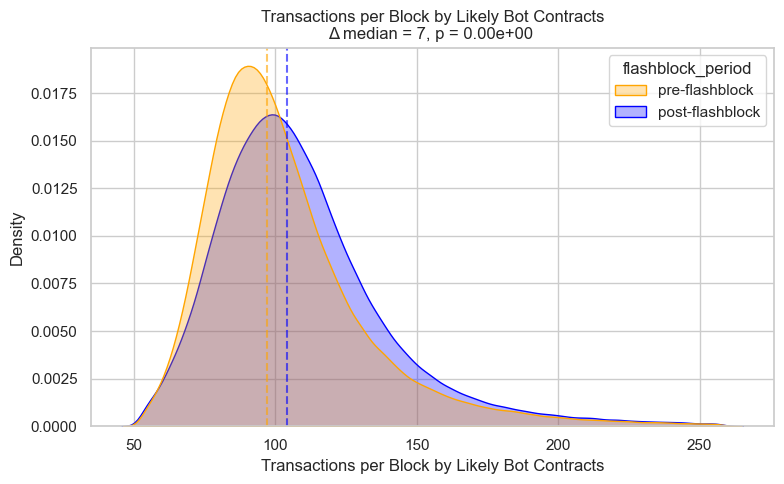

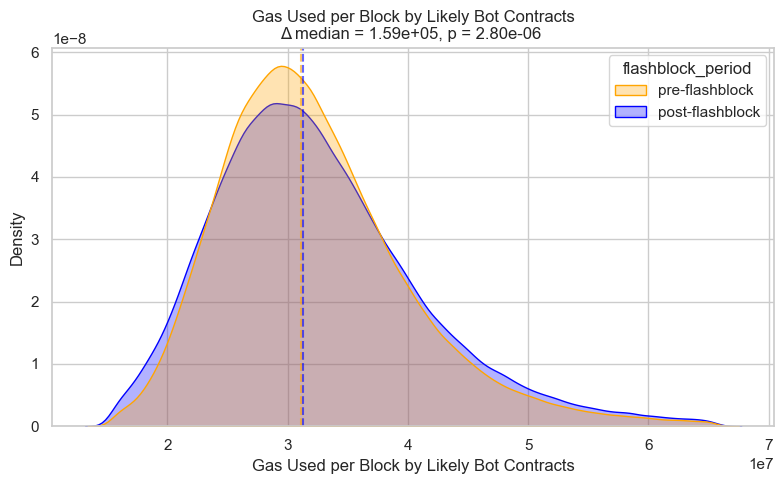

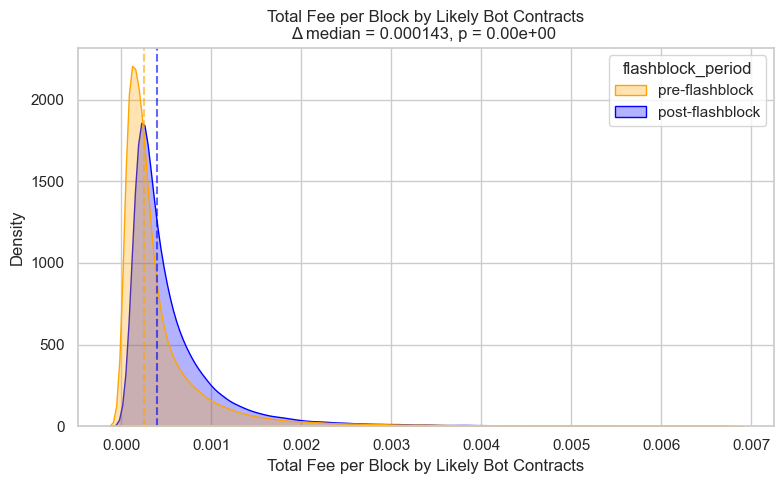

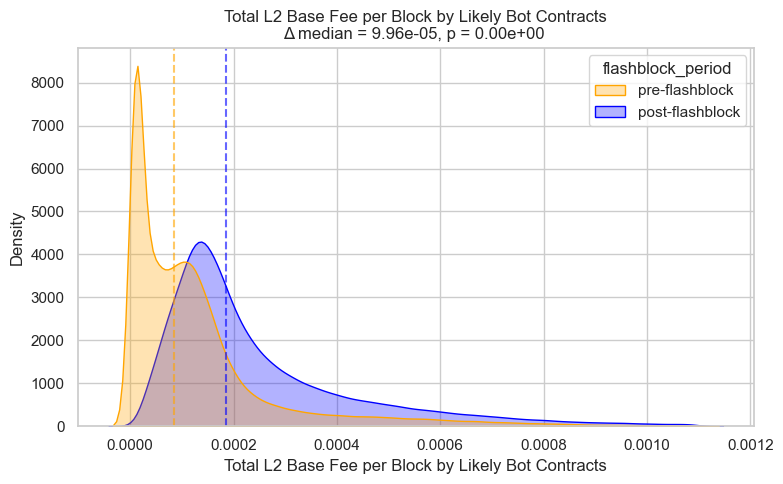

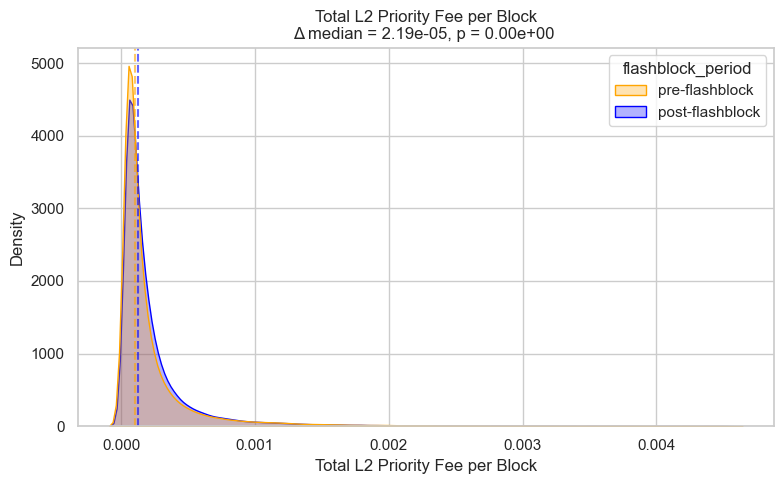

In [23]:
plot_kde_with_stats(block_df_pd, "tx_count", xlabel="Transactions per Block by Likely Bot Contracts")
plot_kde_with_stats(block_df_pd, "total_gas_used", xlabel="Gas Used per Block by Likely Bot Contracts")
plot_kde_with_stats(block_df_pd, "total_fee", xlabel="Total Fee per Block by Likely Bot Contracts")
plot_kde_with_stats(block_df_pd, "total_l2_base_fee", xlabel="Total L2 Base Fee per Block by Likely Bot Contracts")
plot_kde_with_stats(block_df_pd, "total_l2_priority_fee", xlabel="Total L2 Priority Fee per Block")

In [26]:
SAMPLE_SIZE = 50_000
TX_INDEX_CUTOFF = 250

# Get the unique values for flashblock_period
periods = df_casted.select("flashblock_period").unique().to_series().to_list()

# Sample each group separately
sampled_df = (
    df_casted
    .filter(pl.col("transaction_index") <= TX_INDEX_CUTOFF)
    .group_by("flashblock_period")
    .map_groups(lambda group: group.sample(n=SAMPLE_SIZE, seed=42))
    .to_pandas()
)

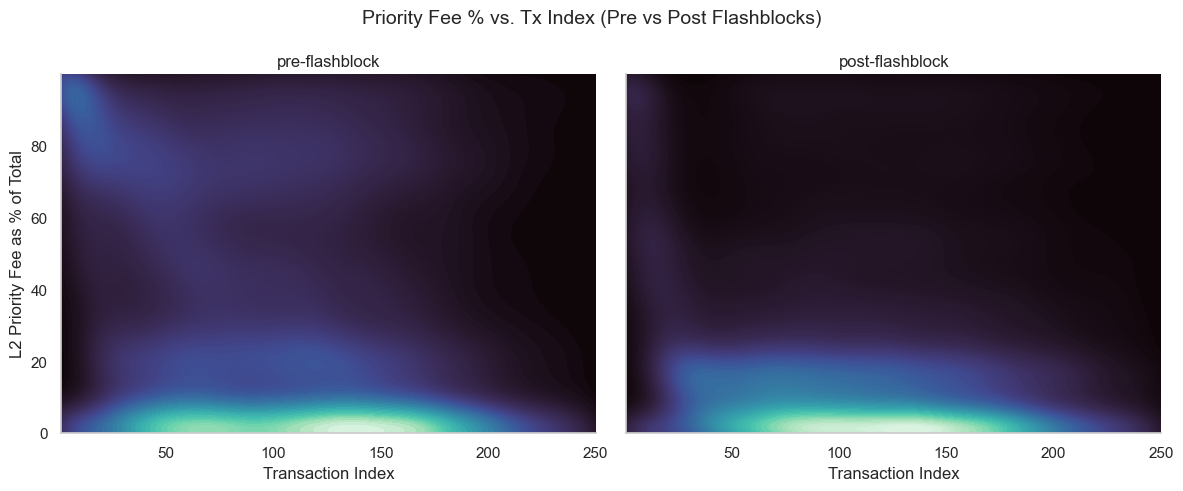

In [30]:
g = sns.FacetGrid(
    sampled_df,
    col="flashblock_period",
    height=5,
    aspect=1.2,
    sharex=True,
    sharey=True
)


# Map KDE plot onto each facet
g.map_dataframe(
    sns.kdeplot,
    x="transaction_index",
    y="pct_l2_priority_fee",
    fill=True,
    thresh=0,
    levels=100,
    cmap="mako",
    common_norm=False,
    cut = 0
)

# Titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Transaction Index", "L2 Priority Fee as % of Total")
g.figure.subplots_adjust(top=0.85)
stat_text = f"{SAMPLE_SIZE} samples with tx_index <= 250"
g.figure.suptitle("Priority Fee % vs. Tx Index (Pre vs Post Flashblocks)", fontsize=14)


plt.show()

# Looking at bot level data

In [31]:
bot_level_df = df_casted.group_by([
    "flashblock_period",
    "to_address",
]).agg([
    pl.len().alias("tx_count"),
    pl.n_unique("block_number").alias("block_count"),
    pl.sum("tx_fee_native").alias("total_fee"),
    pl.sum("l1_fee_native").alias("total_l1_fee"),
    pl.sum("l2_base_fee_native").alias("total_l2_base_fee"),
    pl.sum("l2_priority_fee_native").alias("total_l2_priority_fee"),
    pl.sum("l2_legacy_extra_fee_native").alias("total_l2_legacy_fee"),
    pl.sum("l2_gas_used").alias("total_gas_used"),
    pl.sum("success").alias("total_success"),

    (pl.len().alias("tx_count") / pl.n_unique("block_number")).alias("avg_tx_per_block"),
    pl.mean("tx_fee_native").alias("avg_tx_fee"),
    pl.mean("l1_fee_native").alias("avg_l1_fee"),
    pl.mean("l2_base_fee_native").alias("avg_l2_base_fee"),
    pl.mean("l2_priority_fee_native").alias("avg_l2_priority_fee"),
    pl.mean("l2_legacy_extra_fee_native").alias("avg_l2_legacy_fee"),
    pl.mean("l2_gas_used").alias("avg_l2_gas_used"),

    pl.mean("pct_l1_fee").alias("avg_pct_l1_fee"),
    pl.mean("pct_l2_base_fee").alias("avg_pct_l2_base_fee"),
    pl.mean("pct_l2_priority_fee").alias("avg_pct_l2_priority_fee"),
    pl.mean("pct_l2_legacy_extra_fee").alias("avg_pct_l2_legacy_fee"),
])


In [32]:
COL_TO_RANK = "tx_count"

bot_tx_totals = (
    bot_level_df
    .to_pandas()
    .groupby("to_address", as_index=False)[COL_TO_RANK]
    .sum()
    .sort_values(COL_TO_RANK, ascending=False)
)

# Compute cumulative tx share
bot_tx_totals["tx_cumsum"] = bot_tx_totals["tx_count"].cumsum()
total_txs = bot_tx_totals["tx_count"].sum()
bot_tx_totals["tx_cum_pct"] = bot_tx_totals["tx_cumsum"] / total_txs


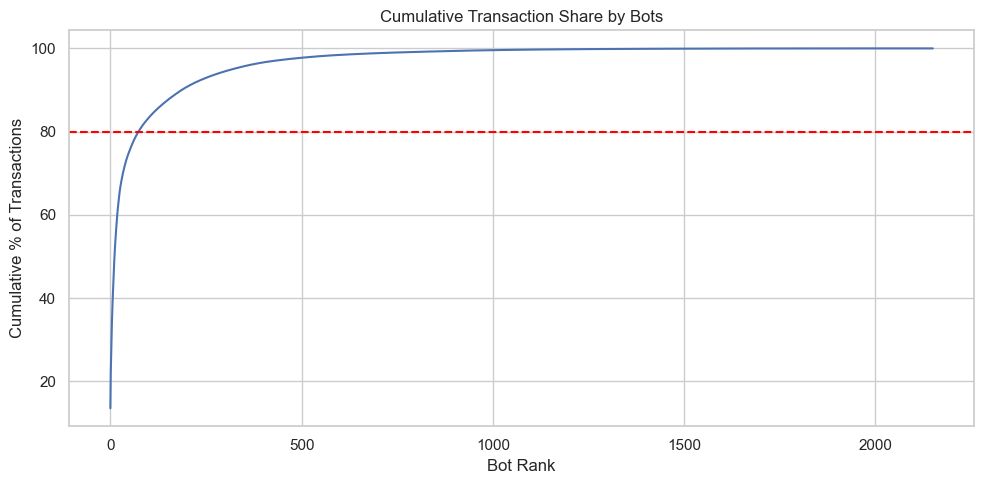

In [33]:
# Select top bots by cumulative threshold
TOP_CUTOFF = 0.80
top_bots = bot_tx_totals[bot_tx_totals["tx_cum_pct"] <= TOP_CUTOFF]
top_bot_addresses = top_bots["to_address"].tolist()

plt.figure(figsize=(10, 5))
plt.plot(bot_tx_totals["tx_cum_pct"].values * 100)
plt.axhline(80, color='red', linestyle='--')
plt.title("Cumulative Transaction Share by Bots")
plt.xlabel("Bot Rank")
plt.ylabel("Cumulative % of Transactions")
plt.tight_layout()
plt.show()

In [ ]:
# Filter bot-level data to only those top bots
df_top_bots = bot_level_df.filter(pl.col("to_address").is_in(top_bot_addresses))

# Find bots active in both periods
top_bot_with_both_periods = (
    df_top_bots
    .group_by("to_address")
    .agg(pl.n_unique("flashblock_period").alias("period_count"))
    .filter(pl.col("period_count") == 2)
    .select("to_address")
)

# Keep only bots with both pre and post entries
df_top_bots_with_both = df_top_bots.join(top_bot_with_both_periods, on="to_address")

In [44]:
num_top_bots = len(top_bot_addresses)
num_bots_retained = df_top_bots_with_both["to_address"].n_unique()
bot_retention_pct = num_bots_retained / num_top_bots

tx_retained = df_top_bots_with_both["tx_count"].sum()
tx_total = df_top_bots["tx_count"].sum()
tx_retention_pct = tx_retained / tx_total

print(f"Top bots with both pre/post entries: {num_bots_retained} / {num_top_bots} ({bot_retention_pct:.2%})")
print(f"Transactions retained after filtering: {tx_retained:,} / {tx_total:,} ({tx_retention_pct:.2%})")


Top bots with both pre/post entries: 56 / 74 (75.68%)
Transactions retained after filtering: 45,246,307 / 56,763,645 (79.71%)


In [ ]:
df_temp = df_top_bots_with_both.to_pandas()
pivoted_top_bots_with_both = df_temp.pivot(index="to_address", columns="flashblock_period")

# Flatten MultiIndex columns
pivoted_top_bots_with_both.columns = ["_".join(col).strip() for col in pivoted_top_bots_with_both.columns]
pivoted_top_bots_with_both = pivoted_top_bots_with_both.dropna() 

# Compute deltas
pivoted_top_bots_with_both["delta_tx_per_block"] = pivoted_top_bots_with_both["avg_tx_per_block_post-flashblock"] - pivoted_top_bots_with_both["avg_tx_per_block_pre-flashblock"]
pivoted_top_bots_with_both["delta_priority_fee"] = pivoted_top_bots_with_both["avg_l2_priority_fee_post-flashblock"] - pivoted_top_bots_with_both["avg_l2_priority_fee_pre-flashblock"]
pivoted_top_bots_with_both["delta_base_fee"] = pivoted_top_bots_with_both["avg_l2_base_fee_post-flashblock"] - pivoted_top_bots_with_both["avg_l2_base_fee_pre-flashblock"]
pivoted_top_bots_with_both["delta_gas_used"] = pivoted_top_bots_with_both["avg_l2_gas_used_post-flashblock"] - pivoted_top_bots_with_both["avg_l2_gas_used_pre-flashblock"]

In [46]:
def plot_delta_dumbbell(
    df, 
    pre_col, 
    post_col, 
    delta_col, 
    title, 
    xlabel, 
    figsize=(10, 12), 
    unit="", 
    color_pre="black", 
    color_post="dodgerblue"
):
    df = df.sort_values(delta_col)
    y = range(len(df))

    fig, ax = plt.subplots(figsize=figsize)

    # Horizontal connecting lines
    ax.hlines(y, df[pre_col], df[post_col], color="lightgray", linewidth=2, zorder=1)

    # Pre dots
    ax.scatter(df[pre_col], y, color=color_pre, s=60, zorder=2, label="Pre")
    # Post dots
    ax.scatter(df[post_col], y, color=color_post, s=60, zorder=3, label="Post")

    # Delta box labels
    for i, (start, end, delta) in enumerate(zip(df[pre_col], df[post_col], df[delta_col])):
        mid = (start + end) / 2
        label = f"{delta:+.0f}{unit}"
        ax.text(mid, y[i], label, ha="center", va="center", fontsize=8,
                bbox=dict(facecolor="#f7c6ce", edgecolor="none", boxstyle="round,pad=0.3"))

    ax.set_yticks(y)
    ax.set_yticklabels(df.index)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.grid(axis='x', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

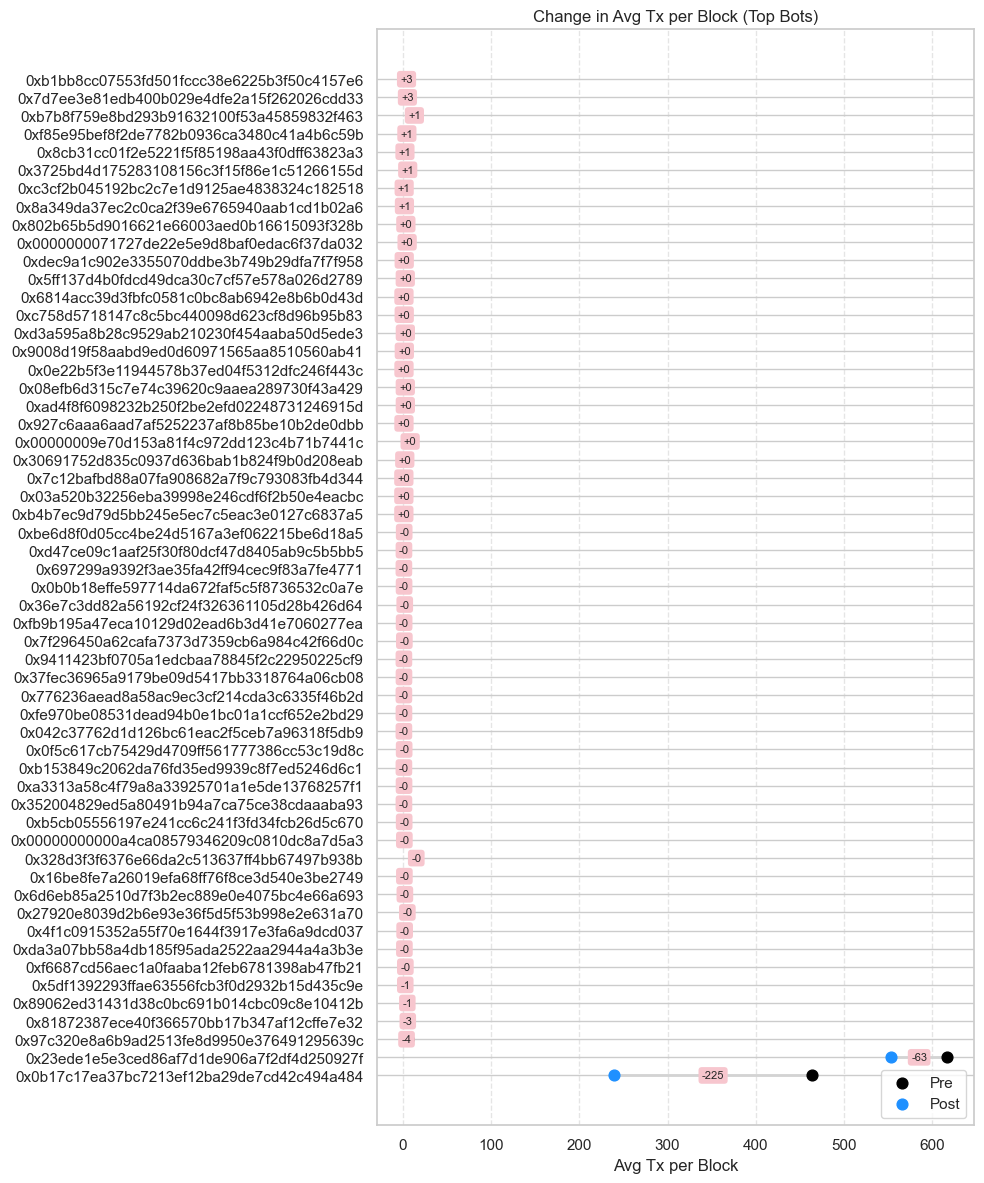

In [48]:
plot_delta_dumbbell(
    df=pivoted_top_bots_with_both,
    pre_col="avg_tx_per_block_pre-flashblock",
    post_col="avg_tx_per_block_post-flashblock",
    delta_col="delta_tx_per_block",
    title="Change in Avg Tx per Block (Top Bots)",
    xlabel="Avg Tx per Block"
)


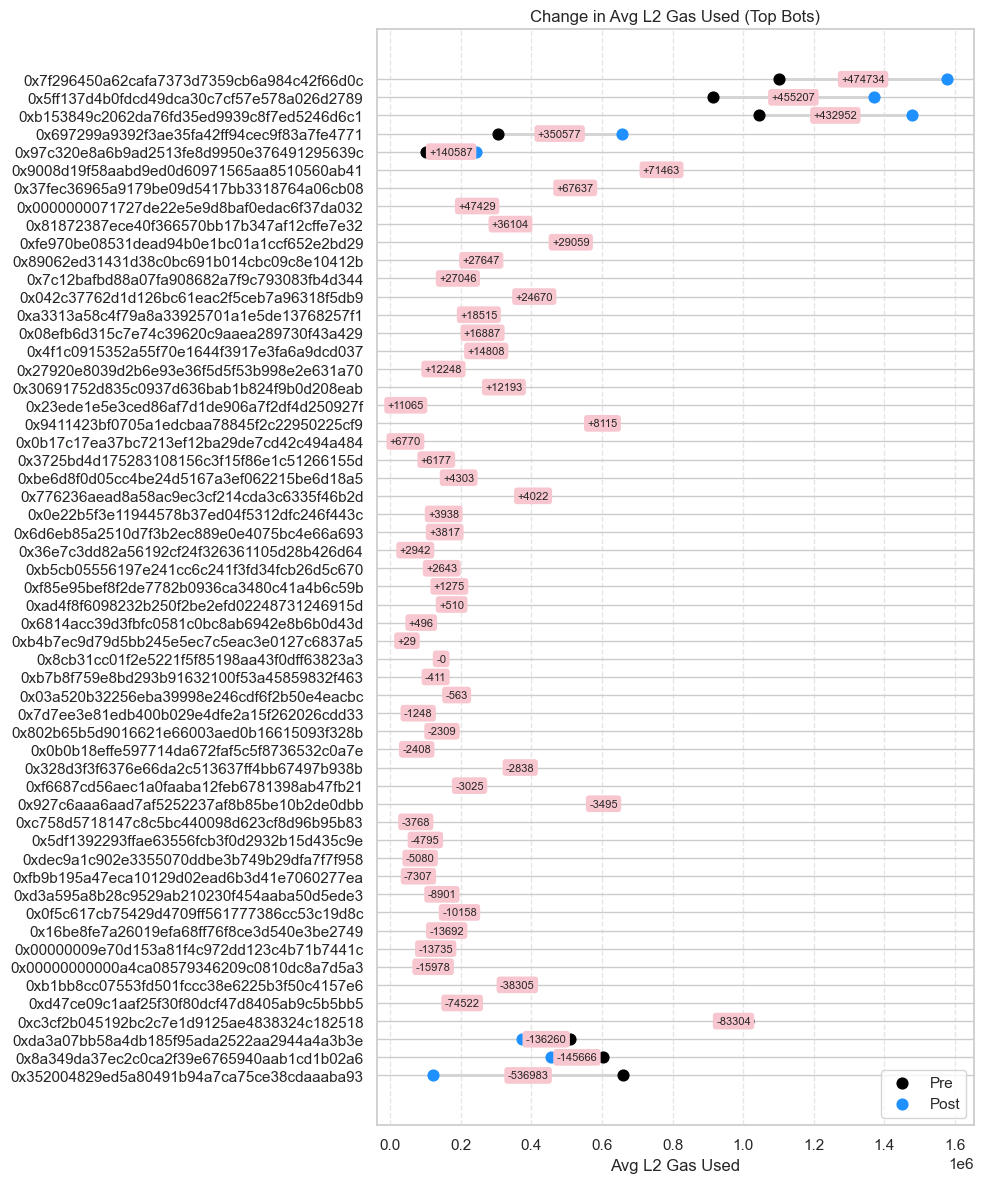

In [64]:
plot_delta_dumbbell(
    df=pivoted_top_bots_with_both,
    pre_col="avg_l2_gas_used_pre-flashblock",
    post_col="avg_l2_gas_used_post-flashblock",
    delta_col="delta_gas_used",
    title="Change in Avg L2 Gas Used (Top Bots)",
    xlabel="Avg L2 Gas Used"
)


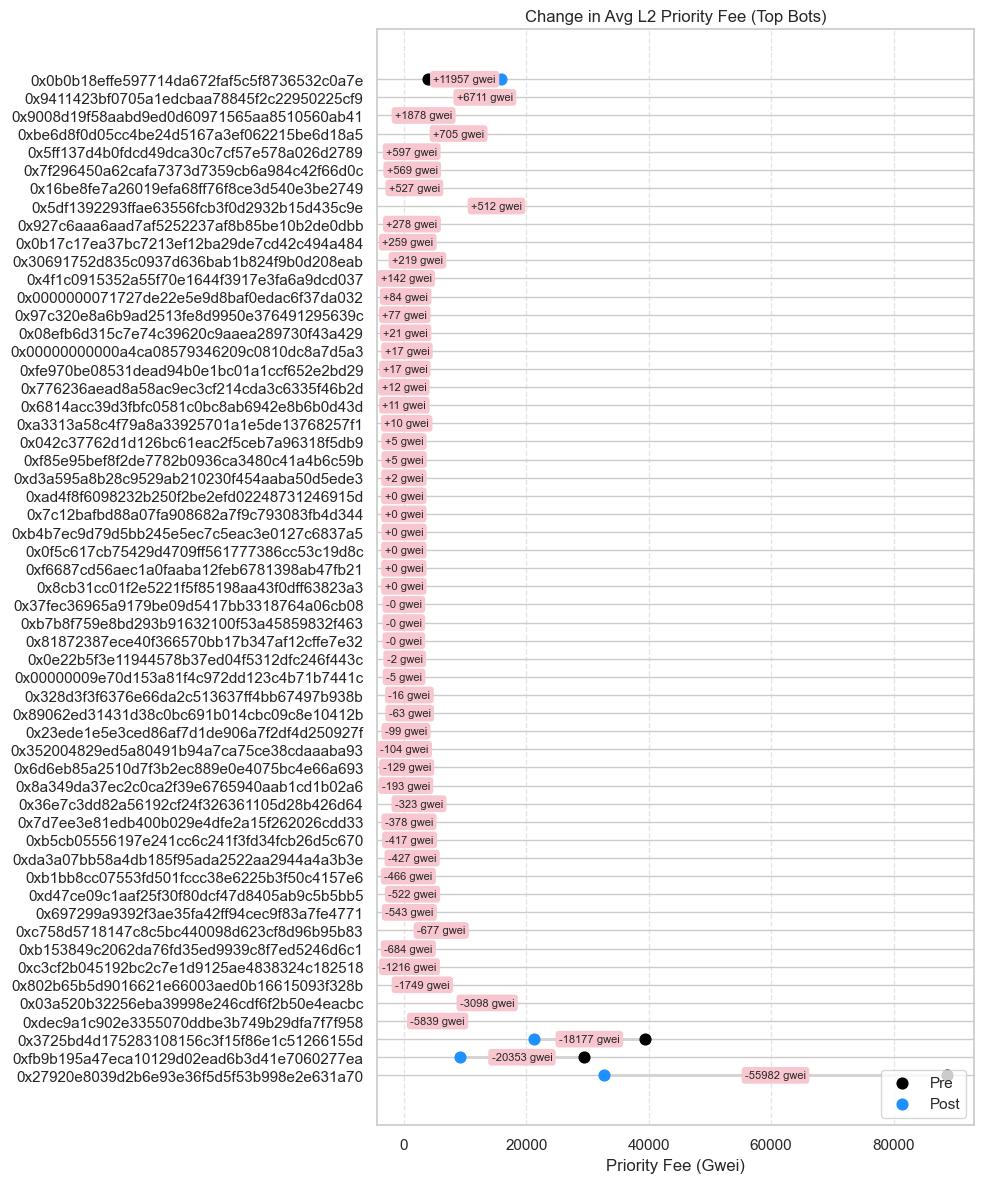

In [67]:
pivoted_top_bots_with_both["gwei_pre"] = pivoted_top_bots_with_both["avg_l2_priority_fee_pre-flashblock"] * 1e9
pivoted_top_bots_with_both["gwei_post"] = pivoted_top_bots_with_both["avg_l2_priority_fee_post-flashblock"] * 1e9
pivoted_top_bots_with_both["delta_gwei"] = pivoted_top_bots_with_both["gwei_post"] - pivoted_top_bots_with_both["gwei_pre"]

plot_delta_dumbbell(
    df=pivoted_top_bots_with_both,
    pre_col="gwei_pre",
    post_col="gwei_post",
    delta_col="delta_gwei",
    title="Change in Avg L2 Priority Fee (Top Bots)",
    xlabel="Priority Fee (Gwei)",
    unit=" gwei"
)


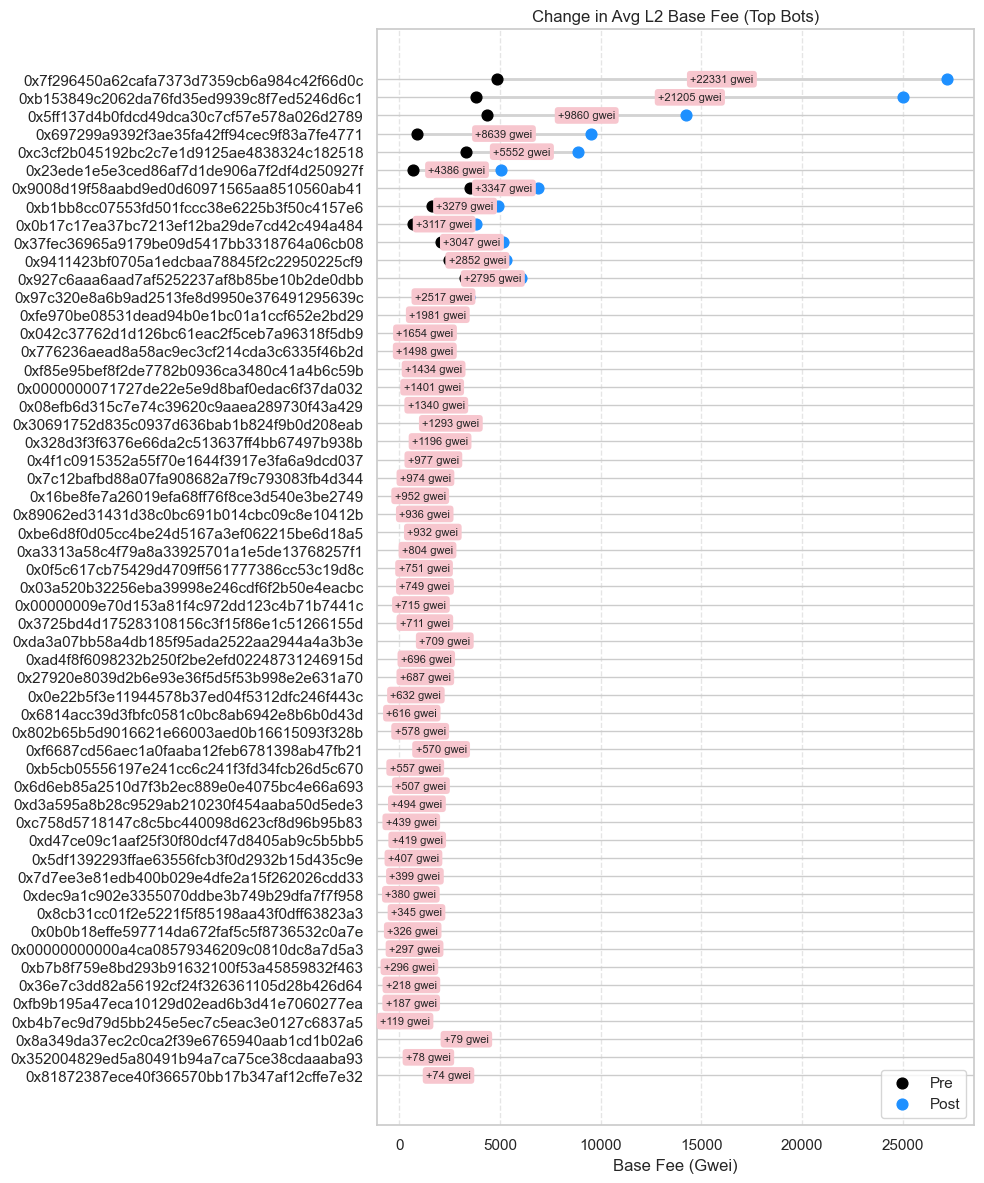

In [68]:
pivoted_top_bots_with_both["gwei_pre"] = pivoted_top_bots_with_both["avg_l2_base_fee_pre-flashblock"] * 1e9
pivoted_top_bots_with_both["gwei_post"] = pivoted_top_bots_with_both["avg_l2_base_fee_post-flashblock"] * 1e9
pivoted_top_bots_with_both["delta_gwei"] = pivoted_top_bots_with_both["gwei_post"] - pivoted_top_bots_with_both["gwei_pre"]

plot_delta_dumbbell(
    df=pivoted_top_bots_with_both,
    pre_col="gwei_pre",
    post_col="gwei_post",
    delta_col="delta_gwei",
    title="Change in Avg L2 Base Fee (Top Bots)",
    xlabel="Base Fee (Gwei)",
    unit=" gwei"
)

In [85]:
df_single_period_bots = df_top_bots.filter(
    ~pl.col("to_address").is_in(top_bot_with_both_periods["to_address"])
)

dual_period_bots = (
    df_top_bots_with_both
    .filter(pl.col("flashblock_period") == "post-flashblock")
    .with_columns(pl.lit("dual periods").alias("bot_type"))
)

post_only_bots = (
    df_single_period_bots
    .filter(pl.col("flashblock_period") == "post-flashblock")
    .with_columns(pl.lit("post-flashblock only").alias("bot_type"))
)

# Combine and materialize
df_top_bots_post = pl.concat([dual_period_bots, post_only_bots])



In [91]:
df_top_bots_post.head()

flashblock_period,to_address,tx_count,block_count,total_fee,total_l1_fee,total_l2_base_fee,total_l2_priority_fee,total_l2_legacy_fee,total_gas_used,total_success,avg_tx_per_block,avg_tx_fee,avg_l1_fee,avg_l2_base_fee,avg_l2_priority_fee,avg_l2_legacy_fee,avg_l2_gas_used,avg_pct_l1_fee,avg_pct_l2_base_fee,avg_pct_l2_priority_fee,avg_pct_l2_legacy_fee,bot_type
str,str,u32,u32,f64,f64,f64,f64,f64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""post-flashblock""","""0xf6687cd56aec1a0faaba12feb6781398ab47fb21""",56697,22828,1.306572,0.001059,0.134081,0.0,1.171432,12663316630,4818,2.48366,0.000023,1.8687e-8,0.000002,0.0,0.000021,223350.735136,0.098958,11.56766,0.0,88.333381,"""dual periods"""
"""post-flashblock""","""0xa3313a58c4f79a8a33925701a1e5de13768257f1""",70146,60944,0.164209,0.004757,0.126677,0.032775,0.0,18273072041,12407,1.150991,0.000002,6.7818e-8,0.000002,4.6724e-7,0.0,260500.556568,3.215982,75.523081,21.260937,0.0,"""dual periods"""
"""post-flashblock""","""0xb1bb8cc07553fd501fccc38e6225b3f50c4157e6""",137473,24528,0.752986,0.008377,0.674693,0.069916,0.0,46880747251,137472,5.604737,0.000005,6.0934e-8,0.000005,5.0858e-7,0.0,341017.852604,1.696485,86.662657,11.640858,0.0,"""dual periods"""
"""post-flashblock""","""0x0b17c17ea37bc7213ef12ba29de7cd42c494a484""",172938,724,0.791,0.004653,0.655187,0.131159,0.0,8036243789,172938,238.864641,0.000005,2.6908e-8,0.000004,7.5842e-7,0.0,46468.929842,1.065065,76.161475,22.773459,0.0,"""dual periods"""
"""post-flashblock""","""0x97c320e8a6b9ad2513fe8d9950e376491295639c""",6258,3297,0.022914,0.000102,0.021621,0.001192,0.0,1520425317,6258,1.898089,0.000004,1.6268e-8,0.000003,1.9040e-7,0.0,242957.065676,1.093757,94.143995,4.762248,0.0,"""dual periods"""


In [93]:
summary_by_bot_type = (
    df_top_bots_post
    .group_by("bot_type")
    .agg([
        # Totals
        pl.sum("tx_count").alias("total_tx"),
        pl.sum("total_fee").alias("total_fees"),
        pl.sum("total_gas_used").alias("total_gas"),

        (pl.sum("tx_count") / pl.sum("block_count")).alias("avg_tx_per_block"),
        (pl.sum("total_gas_used") / pl.sum("block_count")).alias("avg_gas_used_per_block"),

        (pl.sum("total_fee") / pl.sum("block_count")).alias("avg_fee_per_block"),
        (pl.sum("total_l2_base_fee") / pl.sum("block_count")).alias("avg_l2_base_fee_per_block"),
        (pl.sum("total_l2_priority_fee") / pl.sum("block_count")).alias("avg_l2_priority_fee_per_block"),

    ])
    .sort("bot_type")
)

summary_by_bot_type.to_pandas()


,bot_type,total_tx,total_fees,total_gas,avg_tx_per_block,avg_gas_used_per_block,avg_fee_per_block,avg_l2_base_fee_per_block,avg_l2_priority_fee_per_block
0,dual periods,20475436,119.424953,5591298254942,4.142629,1.131242e+06,0.000024,0.000010,0.000013
1,post-flashblock only,7604553,18.350852,2098211851311,6.962965,1.921188e+06,0.000017,0.000014,0.000002
